# Module 1
## Lab 1: Single Node GPUs and Optimizations

Our eventual goal here is to run Llama at scale, on a cluster for training or inference. In order to do that, we first need to ensure we utilize 1 accelerator (or GPU in this case) to the best we can. If we can do that, when we run our model at scale, we'll gain the benefits at scale.

In this lab we will demonstrate how you can optimize code to fully leverage a **single GPU resource**. This will leverage the "Roofline Model" concepts as well as algorithmic intensity to demonstrate these foundational concepts in action.

## Why Cover this Content?
This content is meant to serve as foundational knowledge for distributed machine learning. You may not do a Roofline analysis or matrix multiplications yourself, but understanding this concept will make it clear later on why we use certain frameworks, techniques, and how we think about scaling our workload. This content will equip you in the future as you're making decisions you will be informed on the impact. But we can't do that without understanding out a single unit operates (one GPU). As we go on these concepts will be necessary for fully engaging with the content.

### Pre-requisite Knowledge
We highly suggest you read up on the [roofline model](https://jax-ml.github.io/scaling-book/roofline/), this is more about execution than education of the concept itself.

We will be using [matrix multiplications](https://www.mathsisfun.com/algebra/matrix-introduction.html) or [GEMM operations](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#) so we suggest you learn a bit about those before diving in.

Understanding basic [GPU hardware](https://www.cudocompute.com/blog/a-beginners-guide-to-nvidia-gpus) will be helpful.

### In This Lab You Will:
- See the benefits of changing hyperparameters for price-performance
- Run a series of benchmarks using synthetic GEMM workloads.
- Visualize performance using a **Roofline model**.
- Learn how to identify when you're **memory-bound**, **bandwidth-bound**, or **compute-bound**.
- See how performance improves with **batching** even on a single GPU.

In the **next lab**, we will expand on these concepts by distributing the workload across **multiple GPUs** using a distributed training framework. This will demonstrate how to scale beyond a single node and identify new bottlenecks as compute capacity increases.

Let's get started.

> If you run into issues check the [FAQ](./faq.md)

## Imports and GPU Information
Here we import the relevant libraries and retrieve detailed information about the available GPUs in our environment. We use pynvml to get low-level GPU metrics (e.g., name, memory size, clock speeds), and set up any necessary environment variables (like PyTorch memory allocations). This step helps us understand and confirm our hardware configuration.

In [1]:
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(parent_dir)

In [2]:
%pip install torch pynvml matplotlib numpy bitsandbytes torch ipywidgets torchvision fvcore deepspeed==0.16.2 transformers==4.47.1 accelerate==1.2.1
%pip install --upgrade pip setuptools wheel cython ninja
%pip install flash-attn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
!sudo yum install -y libaio-devel # For Amazon Linux
# !sudo apt-get update && sudo apt-get install -y libaio-dev # For Ubuntu

Last metadata expiration check: 2:13:52 ago on Thu May 22 17:48:53 2025.
Package libaio-devel-0.3.111-11.amzn2023.0.2.x86_64 is already installed.
Dependencies resolved.
Nothing to do.
Complete!


In [4]:
import torch
import pynvml
import os


# Configure PyTorch memory
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

pynvml.nvmlInit()
num_gpus = pynvml.nvmlDeviceGetCount()
memory_bandwidth_tb_s = 0.3

print(f"Available GPUs: {num_gpus}")

gpu_info = {}
for i in range(num_gpus):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    name = pynvml.nvmlDeviceGetName(handle)
    memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    mem_total_tb = memory_info.total / (1024 ** 3)
    clock_info = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS)
    mem_clock_info = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM)
    compute_capability = torch.cuda.get_device_capability(i)
    
    gpu_info[i] = {
        'name': name,
        'memory_tb': mem_total_tb,
        'gpu_clock_mhz': clock_info,
        'mem_clock_mhz': mem_clock_info,
        'memory_bandwidth_tb_s': memory_bandwidth_tb_s,
        'compute_capability': compute_capability
    }
    
    print(f"GPU {i}: {name}")
    print(f"  Memory: {mem_total_tb:.2f} GB")
    print(f"  GPU Clock: {clock_info} MHz")
    print(f"  Memory Clock: {mem_clock_info} MHz")
    print(f"  Approx. Memory Bandwidth: {memory_bandwidth_tb_s:.2f} TB/s")
    print(f"  Compute Capability: {compute_capability}")

gpu_info = [gpu_info[0]]

pynvml.nvmlShutdown()
print("\nNote: For detailed CUDA core and tensor core counts, refer to NVIDIA official GPU specifications.")


Available GPUs: 4
GPU 0: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 1: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 2: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 3: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)

Note: For detailed CUDA core and tensor core counts, refer to NVIDIA official GPU specifications.


We see 4 GPUs here but we'll only be focused on the first 1

## Our Baseline
To start let's first try to run the model we're aiming for and see how long it takes to run: llama. We probably can't fit our larger model yet with 1 GPU, but let's start with a small version just to get an understanding of what we're working with. We'll run a single batch size. This should give us the fastest response time, so why not try it?

In [5]:
import torch
import time
import random
import string
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.optim import AdamW

model_name = "NousResearch/Llama-3.2-1B"
dtype      = torch.bfloat16  # or torch.float16 / torch.float32
device     = torch.device("cuda:0")

# 1) Load tokenizer & model
tok = AutoTokenizer.from_pretrained(model_name)
tok.pad_token = tok.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=dtype,
    attn_implementation="eager"
)

# 2) Disable caching & fusing
model.config.use_cache = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

# 3) Move to GPU & switch to train mode
model = model.to(device).train()

# 4) Prepare a small synthetic training batch
seq_len = 32
batch   = 2
prompt  = tok.bos_token + ''.join(random.choices(string.ascii_letters, k=seq_len - 1))
inputs  = tok([prompt] * batch, return_tensors="pt", padding=True).to(device)
labels  = inputs.input_ids.clone()

# 5) Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# 6) Warm-up (forward + backward)
for _ in range(2):
    outputs = model(input_ids=inputs.input_ids, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.zero_grad()
torch.cuda.synchronize()

# 7) Time one training step
start_evt = torch.cuda.Event(enable_timing=True)
end_evt   = torch.cuda.Event(enable_timing=True)

start_evt.record()
# forward + backward + step
outputs = model(input_ids=inputs.input_ids, labels=labels)
loss = outputs.loss
loss.backward()
optimizer.step()
optimizer.zero_grad()
end_evt.record()

torch.cuda.synchronize()
elapsed_s = start_evt.elapsed_time(end_evt) / 1e3  # ms → s

print(f"One training step: {elapsed_s:.4f}s, loss = {loss.item():.4f}")


One training step: 0.2832s, loss = 7.4283


In [6]:
import importlib
import src.utils.model_utils as mutils
importlib.reload(mutils)

mutils.theoretical_tflops(
    model=model,
    seq_len=seq_len,
    batch=batch,
    elapsed_s=elapsed_s
)

mutils.estimate_cost_per_1m_tokens(
    tokens_generated=seq_len * batch,
    elapsed_s=elapsed_s,
    price_per_hour=1.21
)


[2025-05-22 20:02:51,104] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Batch=2 | SeqLen=32
Elapsed GPU time: 0.2832s | TFLOP/s: 5.6 | AI: 45.71 FLOP/B
--------- OUTPUT BREAKDOWN ---------
🧠 Tokens generated: 64
⚡ Throughput: 226.01044 tokens/sec
⏱️ Total time: 0.28317 sec
💸 Cost per 1M tokens: $1.48715
------------------------------------


1.4871486094262862

As you can see we have an effective rate for how many tokens/sec we can generatea nd a price for 1 million tokens. It'd be nice if we could reduce that price. As you may have heard, batching can more effectively utilize the GPU. Let's see that in action, we'll start with batching 2 calls together at once.

> We've abstracted the model below into the library but it should be the same as above.

In [7]:
import importlib
import src.utils.model_utils as mutils
importlib.reload(mutils)

batch = 2
seq_len = 32

elapsted_s, tokens_generated, _, _ = mutils.benchmark_llm(model, tok,
                         batch=batch, seq_len=seq_len)



Batch=2 | SeqLen=32
Elapsed GPU time: 0.3567s | TFLOP/s: 4.4 | AI: 45.71 FLOP/B
--------- OUTPUT BREAKDOWN ---------
🧠 Tokens generated: 64
⚡ Throughput: 179.42962 tokens/sec
⏱️ Total time: 0.35669 sec
💸 Cost per 1M tokens: $1.87322
------------------------------------


That's a major improvement! As you can see we've dropped our cost by half, for a negligible latency trade-off.

But why does this happen? Can we do this forever and make infinite money?? The next section dives into the academics behind why batching increases your throughput, what it's limitations are, and how to more effectively utilize your GPU.

## The Roofline Model 

This section will dive deeper into the academics behind this. Although it's more math focused, this is a very effective way for you to model your model's usage on the hardware of your choice. Utilize this approach to have more clarity in your hardware, batching, and deployment mentality.

The roofline model is a visual performance model that helps us understand the limitations of a computing system, particularly the trade-offs between compute capabilities and memory bandwidth. Batching takes advantage of this relationship to utilize your GPU fully. The roofline model plots the achievable performance -- typically in FLOPS (floating point operations per second basically every single calculation) -- against the arithmetic intensity (FLOPs per byte of memory accessed).

- **Memory-Bound Region:** At low arithmetic intensities, performance is limited by memory bandwidth. In this region, increasing the arithmetic intensity (doing more computation per memory byte) can lead to significant performance improvements.
- **Compute-Bound Region:** At high arithmetic intensities, performance is capped by the peak compute performance of the GPU. Here, even if you increase arithmetic intensity, the performance will not exceed the hardware’s compute limits.
- **Ideal Performance:** The ideal performance on the roofline model is represented by the "roof" — the lowest boundary defined by the compute peak and the memory bandwidth limit. Achieving performance close to this roof indicates that the application is efficiently utilizing the GPU resources, whether it is memory-bound or compute-bound.

This model helps in identifying if your workload is being limited by the speed at which data is moved (memory bandwidth) or by the raw computational power (compute throughput), guiding further optimizations.

Let's look at the roofline model for our current GPU.

<details closed>
<summary>Aside: What is batching</summary>
<br>
When you perform inference with transformer models you typically are doing a matrix multiplication where you multiply the weights of the model by the input. For a single value inference this matrix multiplication is essentially a 1 by seq_length matrix multiplied by a sequence_length by weight matrix. This means for each layer, you need to load the weights into memory, and the input into memory, essentially doing one calculation while pulling in a lot of memory.

So what's batching? Modern GPUs can do hundreds of teraflops but if you only do one calculation at a time they are starved for data. Batching is when you you increase the number of rows in your input matrix. This will result in a Batch size by seq_length matrix being multiplied by our weight matrix. Batching “fills up” the pipeline: you reuse the weight data across multiple rows, drive up your arithmetic intensity (FLOPs per memory access), and push utilization toward the GPU’s peak.


![image](./batching.png)

With batching, you now get to scale the utilization of your weights by the batch size, and really push the GPU's utilization

</details>

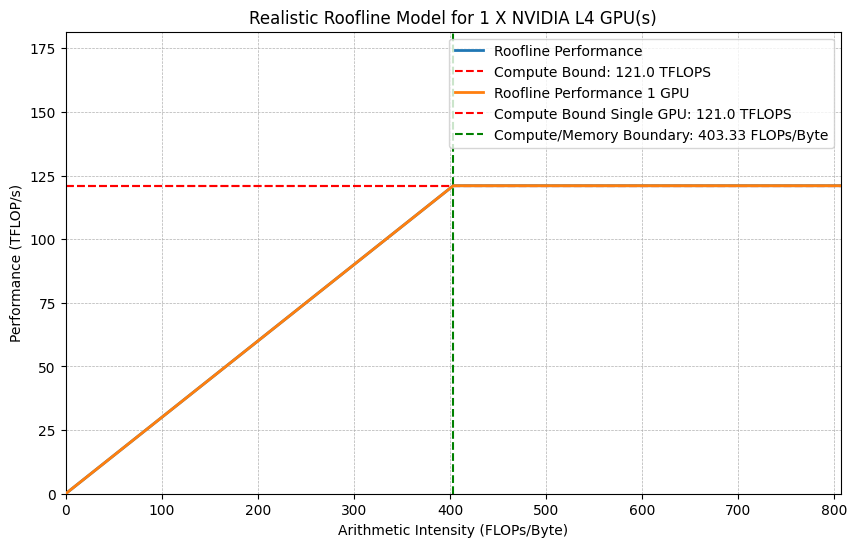

In [8]:
import importlib
import src.utils.plot_utils as putils
importlib.reload(putils)

# Generate an empty roofline model
putils.plot_roofline_chart(gpu_info, [])

### Interpreting the Roofline Model
This graph shows the ideal scenarios for our GPU. The slant in the roof indicates we are capped on the number of operations we can perform per second if the algorithmic intensity is too low. This is due to the memory bandwidth being lower relatively than the power of the compute. If we can do more operations on our data (higher algorithmic intensity) we can work around our memory bottleneck. This is dependent on the algorithm we're running on the GPU. If we can increase this intensity, we can increase the flops, and get closer to the max flops, 125 in this case, of the GPU. This is essentially how we can aim for 100% utilization of the GPU, and get more bang for our buck.

For a deeper dive we suggest you read [this](https://jax-ml.github.io/scaling-book/roofline/).

### Determining the Ideal Arithmetic Intensity
How do we determine this graph? We need to find the ideal Arithmetic Intensity (AI - I know confusing in this context, but for our purposes we will only be referring to this) for our GPU. This will differ for each GPU.

For our GPU (L4), the ideal arithmetic intensity is derived by comparing the hardware's compute capability and its memory bandwidth. Here's how we determined it:

1. **Peak Compute Performance:**  
   We consider the GPU's theoretical peak compute performance (in TFLOPs). For example, our GPU's peak (for FP 16) is set at 121 TFLOPs, which represents the maximum number of floating-point operations it can perform per second. In our case that is **121 TFLOPs**

2. **Memory Bandwidth:**  
   The memory bandwidth (in TB/s) indicates how quickly data can be moved between the GPU memory and its compute cores. In our setup, we use a value extracted from the GPU information, in our case it's **0.3 TB/s**. 

3. **Ideal Arithmetic Intensity (Cross Point):**  
   The ideal arithmetic intensity is the point where the compute-bound performance and the memory-bound performance intersect. It is computed as:
   
$$
\text{AI} = \frac{\text{FLOPs}_{\text{total}}}{\text{Memory}_{\text{total}}} 
$$

For our values, this gives:

$$
\text{Ideal AI} = \frac{121\text{ TFLOPs}}{0.3\text{ TB/s}} \approx 403.33\text{ FLOPs/Byte}
$$

This essentially means for every Byte we load into memory, we should be performing 403 operations in order to take full advantage of our GPU. Hopefully you're starting to think about why batching may take advantage of this pattern...

Moving forward that is what we will try to achieve.

### Determining Algorithmic Intensity of our Algorithm
Now we need to determine the algorithmic intensity (AI) for our specific algorithm. For the purposes of this workshop we are doing simple GEMM operations, or generic matrix multiplications multiple times. Modern transformers are majority made up of GEMM-like operations, so this should be a fairly strong example for how to optimize on a GPU. We load data of size BD and DF into memory, do a matrix multiplication, which will equate to one flop per byte (or an AI of 1). Then for each layer we repeat this. Finally we write the data back to memory. 

If you want more details on how we go this calculation look below. You'll see that we only utilize each bye once, so our goal is to utilize each byte multiple times to take advantage of our GPU...

<details closed>
<summary>Detailed Calculations</summary>
<br>

**Given Configuration:**  
Batch size, dimension, weight size, and layer count are:

$B = 1,\ D = 4096,\ F = 4096,\ L = 5.$

---

**1. Calculate Total FLOPs**  
The total number of floating-point operations (FLOPs) is calculated by summing the operations from the first layer and all remaining layers. The first layer multiplies a $[B, D]$ matrix with a $[D, F]$ matrix, while each additional layer multiplies $[B, F]$ by $[F, F]$.

$$
\begin{aligned}
\text{FLOPs}_{\text{first}} &= 2 \cdot B \cdot D \cdot F = 2 \cdot 1 \cdot 4096 \cdot 4096 = 33\,554\,432,\\[1mm]
\text{FLOPs}_{\text{other}} &= (L-1) \cdot (2 \cdot B \cdot F \cdot F) = 4 \cdot (2 \cdot 1 \cdot 4096 \cdot 4096) = 134\,217\,728,\\[1mm]
\text{FLOPs}_{\text{total}} &= \text{FLOPs}_{\text{first}} + \text{FLOPs}_{\text{other}} = 33\,554\,432 + 134\,217\,728 = 167\,772\,160.
\end{aligned}
$$

---

**2. Estimate Memory Traffic (in Bytes)**  
We estimate the amount of memory read and written (in bytes) by accounting for inputs, weights, and outputs. All tensors use FP16 (2 bytes per element). The memory access pattern is similar for each layer.

$$
\begin{aligned}
\text{Memory}_{\text{first}} &= \Big( B\cdot D + D\cdot F + B\cdot F \Big) \times 2 \\
&= \Big( 4096 + (4096 \times 4096) + 4096 \Big) \times 2 = 33\,570\,816\text{ bytes},\\[1mm]
\text{Memory}_{\text{layer}} &= \Big( B\cdot F + F\cdot F + B\cdot F \Big) \times 2 \\
&= \Big( 4096 + (4096 \times 4096) + 4096 \Big) \times 2 = 33\,570\,816\text{ bytes},\\[1mm]
\text{Memory}_{\text{other}} &= (L-1) \cdot \text{Memory}_{\text{layer}} = 4 \times 33\,570\,816 = 134\,283\,264\text{ bytes},\\[1mm]
\text{Memory}_{\text{total}} &= \text{Memory}_{\text{first}} + \text{Memory}_{\text{other}} = 33\,570\,816 + 134\,283\,264 = 167\,854\,080\text{ bytes}.
\end{aligned}
$$

---

**3. Compute Arithmetic Intensity (AI)**  
Arithmetic intensity is defined as the ratio of total FLOPs to total memory bytes accessed. This tells us how much computation is performed per byte transferred.

$$
\text{AI} = \frac{\text{FLOPs}_{\text{total}}}{\text{Memory}_{\text{total}}} \approx \frac{167\,772\,160}{167\,854\,080} \approx 1\text{ FLOP/Byte.}
$$

---
</details>

With one floating-point operation per byte accessed, this means we're in the **memory-bound** region of the roofline model. Because we're **not** batching, we're sending an inference call in, and out, without any data re-use


### In Practice
Below we'll actually run the algorithm we described. We suggest running `watch nvidia-smi` in a terminal to see the memory and compute usage go up.

In [9]:
import importlib
import src.utils.gemm_utils as gutils
importlib.reload(gutils)

import json

test_suite = { # 1 GPU
        "world_size": 1, 
        "tests": [
            {"batch_size": 1, "D": 4096, "F": 4096, "num_layers": 5}, 
        ]
    }

results = []
gutils.distributed_main(0, test_suite["world_size"], test_suite["tests"])
with open(f"results/distributed_test_suite_results_{test_suite["world_size"]}gpus.json", "r") as f:
    results.append(json.load(f))

print(json.dumps(results, indent=2))


Rank 0 running on GPU 0
PASSED: B=1, D=4096, F=4096, layers=5
  Local TFLOPs: 0.24  |  Aggregated GFLOPs: 0.24
  Total FLOPs: 1.68e+08  |  Estimated Memory: 1.68e+08
  Arithmetic Intensity: 1.000
--------------------------------------------------------------------------------

Test suite complete. Results saved to results/distributed_test_suite_results_1gpus.json
[
  [
    {
      "batch_size": 1,
      "world_size": 1,
      "D": 4096,
      "F": 4096,
      "num_layers": 5,
      "avg_time_seconds": 0.0006885528564453125,
      "tflops_s": 0.24365908648775622,
      "aggregated_gflops": 0.24365907907485962,
      "total_flops": 167772160.0,
      "estimated_memory_bytes": 167854080.0,
      "arithmetic_intensity": 0.9995119570522206
    }
  ]
]


### Construct Roofline Chart
Let's place our newly found data point on the roofline model. Where do you think it will land? Look at the empty one above and give a guess

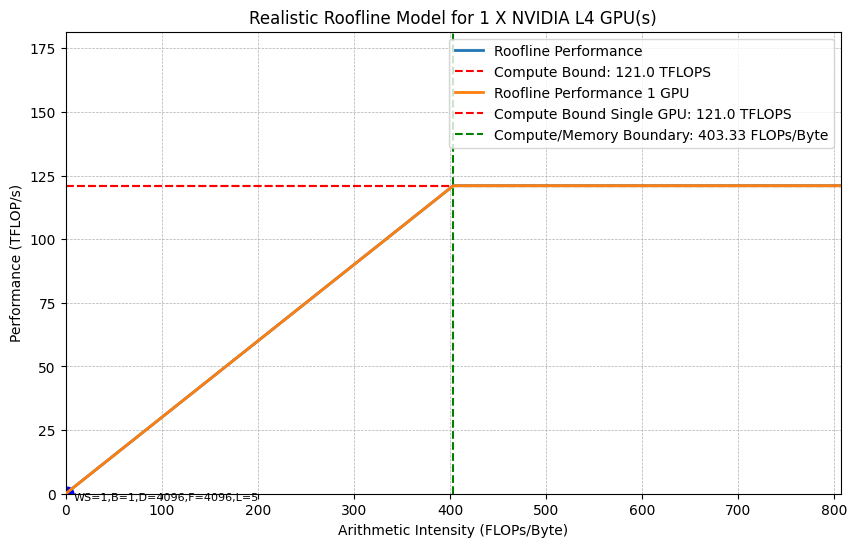

In [10]:
import importlib
import src.utils.plot_utils as putils
importlib.reload(putils)

# Now use it
putils.plot_roofline_chart(gpu_info, results)


See the bottom left? Not great. We can barely get a few flops per second with this algorithm. This essentially means our GPU is idle waiting to load data in and out of memory.

It looks like we're heavily constrained by memory bandwidth, and we need to increase our algorithmic intensity. The easiest way to do this is by increasing the batch size. This is because it increases the amount of data we processes per byte we load into memory. Try to estimate it with the previous algorithm we showed. 

Once you're ready run the code below to see a better usage of our GPU. We've just increased the batch size. Essentially we've done MORE calculations with the same data. In practice, this is like loading a model's weights into memory, and continuing to do inference on them with different inputs, hence, processing a batch of data. There are additional strategies like changing sequence length and quantization that allow you to similarly adjust different ways the memory is being utilized to leverage the compute more effectively. 

Rank 0 running on GPU 0


PASSED: B=512, D=4096, F=4096, layers=5
  Local TFLOPs: 76.84  |  Aggregated GFLOPs: 76.84
  Total FLOPs: 8.59e+10  |  Estimated Memory: 2.10e+08
  Arithmetic Intensity: 409.600
--------------------------------------------------------------------------------

Test suite complete. Results saved to results/distributed_test_suite_results_1gpus.json


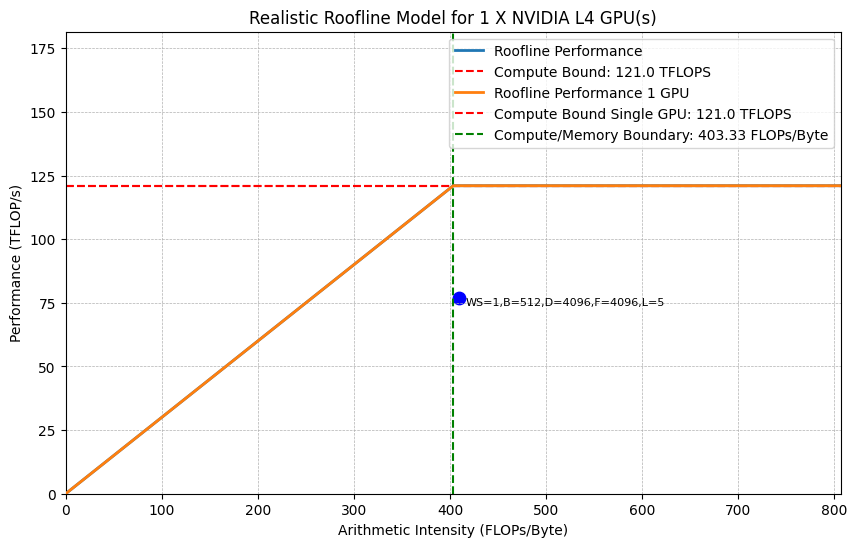

In [11]:
test_suite = { # 1 GPU
        "world_size": 1, 
        "tests": [
            {"batch_size": 512, "D": 4096, "F": 4096, "num_layers": 5}, 
        ]
    }

results = []
gutils.distributed_main(0, test_suite["world_size"], test_suite["tests"])
with open(f"results/distributed_test_suite_results_{test_suite["world_size"]}gpus.json", "r") as f:
    results.append(json.load(f))
    
putils.plot_roofline_chart(gpu_info, results)


Much better!

Why is it not capping out though at TFLOPS? It should hit around 125? The reason is memory bandwidth isn't the only bottleneck, this is where you can continue to dive into optimizations to ensure you're leveraging your GPU effectively, but for now we'll stop here as this is the biggest factor, as you scale, to leverage your GPU appropriately.

## Applying it Back
Now that we're familiar with the roofline model, let's chart it with our real use case: Llama. Let's see what improvements we can get  running llama on our L4 GPUs, and what cost savings we can achieve. We've made a generic version of the previous model call function that loops through different batch sizes. If you're interested go to [model_utils.py](../src/utils/model_utils.py)

Let's try a few different batch sizes (1, 2, 4, 6, and 8), and generate some results around cost, arithmetic intensity, time, and FLOPS.

In [12]:
import torch
import pynvml
import os
import json
import importlib
import src.utils.model_utils as mutils
importlib.reload(mutils)

results = mutils.benchmark_batch_sizes(
    model_name="NousResearch/Llama-3.2-1B",
    seq_len=32,
    batch_sizes=[1, 4, 6, 10, 16, 32],
    dtype=torch.bfloat16,
    world_size=1
)

print(json.dumps(results, indent=2))


🔁 Running batch size = 1
Batch=1 | SeqLen=32
Elapsed GPU time: 0.2762s | TFLOP/s: 2.9 | AI: 22.86 FLOP/B
--------- OUTPUT BREAKDOWN ---------
🧠 Tokens generated: 32
⚡ Throughput: 115.87722 tokens/sec
⏱️ Total time: 0.27615 sec
💸 Cost per 1M tokens: $2.90058
------------------------------------

🔁 Running batch size = 4
Batch=4 | SeqLen=32
Elapsed GPU time: 0.5117s | TFLOP/s: 6.2 | AI: 91.40 FLOP/B
--------- OUTPUT BREAKDOWN ---------
🧠 Tokens generated: 128
⚡ Throughput: 250.12851 tokens/sec
⏱️ Total time: 0.51174 sec
💸 Cost per 1M tokens: $1.34375
------------------------------------

🔁 Running batch size = 6
Batch=6 | SeqLen=32
Elapsed GPU time: 0.5147s | TFLOP/s: 9.2 | AI: 137.09 FLOP/B
--------- OUTPUT BREAKDOWN ---------
🧠 Tokens generated: 192
⚡ Throughput: 373.01239 tokens/sec
⏱️ Total time: 0.51473 sec
💸 Cost per 1M tokens: $0.90107
------------------------------------

🔁 Running batch size = 10
Batch=10 | SeqLen=32
Elapsed GPU time: 0.5337s | TFLOP/s: 14.8 | AI: 228.42 FLOP/B

If you skim through the data you should notice a pattern of the increase in batch size leading to a decrease in price. Nice! 

Let's make some plots here to see the data. First we'll plot our real use case on the roofline model to see our "ridge point" or where we hit our max utilization from an increase in batch size. We'll also plot the batch size vs price to more clearly see the tangible impact of this process.

> Note: These numbers will always be far lower than the theoretical peak, but as you look at the cost you can see a major decrease

I encourage you to fully dive into where the data comes from and why based on our previous explanations, we also cover it in the FAQ: [See Roofline Model explanation](faq.md#q-how-do-i-interpret-the-roofline-model-charts)


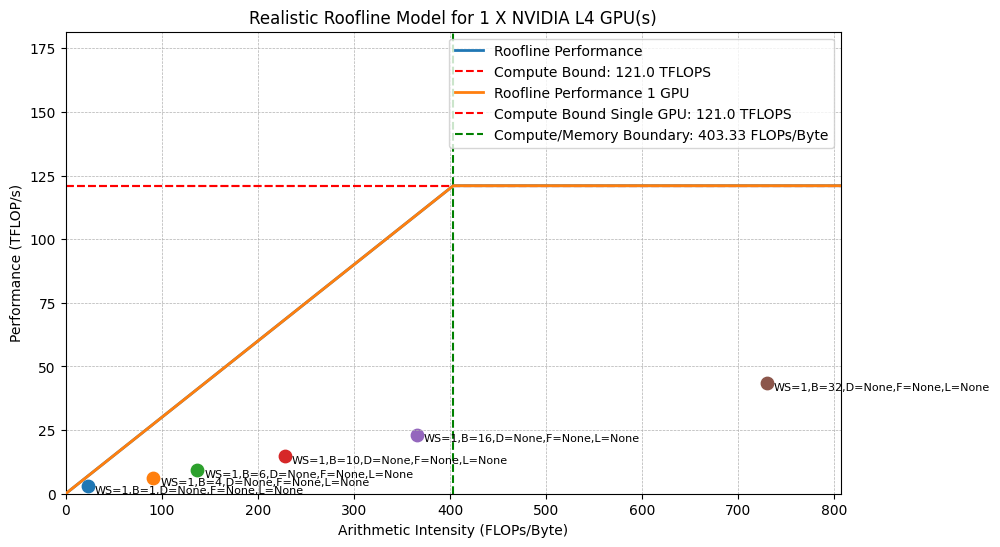

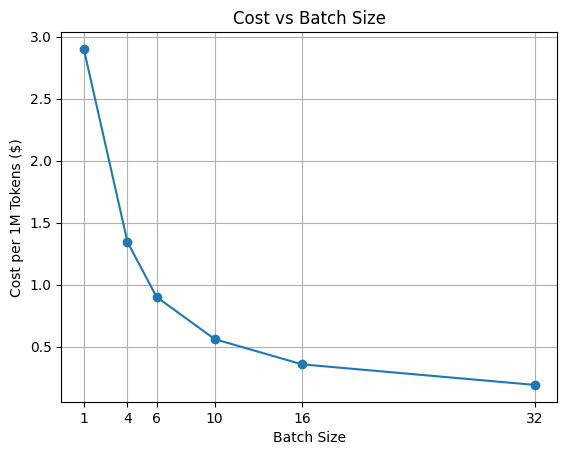

In [13]:
import importlib
import src.utils.plot_utils as putils
importlib.reload(putils)

putils.plot_roofline_chart(gpu_info, results)
putils.plot_cost_vs_batch(results)


### Conclusion
Through this lab we've learned how to utilize batch size to increase throughput and reduce our spend for inference or training workloads. Essentially, we want to ensure we're re-using memory as much as possible, and reduce the time we have to pull from memory to do computations.

You should be able to apply this approach to any model, experimenting across different alterations of the model configurations to leverage it appropriately for your specific hardware.

> Note: Batch size is one lever for this, also consider sequence length, minimum/maximum token generation, and data type (quantization)

In the next lab we'll discuss utilizing *multiple* GPUs and splitting a model across accelerators.